## Multivariate Lasso Regression

### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import ConvergenceWarning

### Data Loading

In [ ]:

# Load the dataset
df = pd.read_csv('https://drive.google.com/uc?id=1sbFAHLYmyOBhHZ8yHqct2yhViRRV9r3u')

In [ ]:
df.head()

,TimeStamp,WindSpeed_Mean,VoltL1_Mean,VoltL2_Mean,VoltL3_Mean,ActivePower_Mean,CurrentL1_Mean,CurrentL2_Mean,CurrentL3_Mean,PowerFactor_Mean,Frequency_Mean,WindSpeed_Bin
0,2016-01-01 00:00:00,6.785655,392.817993,393.226410,392.404510,521.591797,588.076599,588.153687,588.288208,0.735540,50.030361,6.8
1,2016-01-01 00:10:00,6.085925,392.750610,393.095093,392.344208,352.522308,491.073486,491.226807,491.788910,0.564326,49.993130,6.1
2,2016-01-01 00:20:00,5.824687,393.093109,393.321503,392.433807,294.078888,472.158508,472.661804,472.771088,0.512421,49.952190,5.8
3,2016-01-01 00:30:00,7.100197,393.863586,394.046600,393.028595,587.302795,674.494019,674.627991,674.614319,0.705167,49.975941,7.1
4,2016-01-01 00:40:00,8.232280,394.487793,394.654785,393.713715,881.533325,866.352600,866.474121,865.911682,0.840677,49.930500,8.2


In [ ]:
df_MLP = df.drop(columns=['TimeStamp','WindSpeed_Bin'])

In [ ]:
df_MLP.head()

,WindSpeed_Mean,VoltL1_Mean,VoltL2_Mean,VoltL3_Mean,ActivePower_Mean,CurrentL1_Mean,CurrentL2_Mean,CurrentL3_Mean,PowerFactor_Mean,Frequency_Mean
0,6.785655,392.817993,393.226410,392.404510,521.591797,588.076599,588.153687,588.288208,0.735540,50.030361
1,6.085925,392.750610,393.095093,392.344208,352.522308,491.073486,491.226807,491.788910,0.564326,49.993130
2,5.824687,393.093109,393.321503,392.433807,294.078888,472.158508,472.661804,472.771088,0.512421,49.952190
3,7.100197,393.863586,394.046600,393.028595,587.302795,674.494019,674.627991,674.614319,0.705167,49.975941
4,8.232280,394.487793,394.654785,393.713715,881.533325,866.352600,866.474121,865.911682,0.840677,49.930500


### Model Class

In [ ]:
class MultivariateLassoRegression:
    def __init__(self, alpha=1.0, max_iter=1000):
        self.alpha = alpha  # Regularization parameter for Lasso
        self.max_iter = max_iter  # Maximum iterations for the Lasso algorithm
        self.model = None  # Placeholder for the Lasso model
        self.scaler = MinMaxScaler()  # MinMaxScaler for feature scaling

    def preprocess_data(self, df, target_column):

        # Drop the target column and get the feature set X
        X = df.drop(columns=[target_column])  # Ensure the target column is not included in the features
        y = df[target_column]  # Extract the target variable

        # Scale the features using MinMaxScaler
        X_scaled = self.scaler.fit_transform(X)  # Apply scaling
        return X_scaled, y

    def split_data(self, X, y):

        # Split the data into 70% training, 15% validation, and 15% testing
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        return X_train, X_val, X_test, y_train, y_val, y_test

    def fit_model(self, X_train, y_train):

        # Suppress convergence warnings during alpha tuning
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        # LassoCV with logarithmic alpha grid, more iterations, and tolerance
        self.model = LassoCV(
            alphas=np.logspace(-6, 0, 60),
            cv=5,
            max_iter=self.max_iter,
            tol=1e-4,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(X_train, y_train)
        self.alpha_ = self.model.alpha_
        print(f"Selected alpha: {self.alpha_:.5f}")

        mse_path = np.mean(self.model.mse_path_, axis=1)
        plt.semilogx(self.model.alphas_, mse_path, marker='o')
        plt.axvline(self.model.alpha_, color='red', linestyle='--')
        plt.xlabel('α'); plt.ylabel('CV MSE')
        plt.title('LassoCV: MSE vs. α'); plt.show()


    def evaluate_model(self, X, y):

        y_pred = self.model.predict(X)  # Make predictions

        eps= 1e-2
        mask = y> eps

        if np.sum(mask) == 0:
            print("[Warning] No valid values after masking low y_true values.")
            return {}

        y = y[mask]
        y_pred = y_pred[mask]
        pct = (y_pred - y) / (y)

        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mean_y = np.mean(y)
        rmsep_approx = (rmse /mean_y) * 100
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        smape = np.mean(2.0 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred) + eps)) * 100

        metrics = {
        'RMSE': rmse,
        'RMSEP_approx (%)': rmsep_approx,
        'R2': r2,
        'MAE': mae,
        'SMAPE (%)': smape
        }

        return metrics

    def get_selected_features(self, df, target_column):

        selected_features = np.where(self.model.coef_ != 0)[0]  # Get the selected feature indices

        # Get the feature names from the original DataFrame (excluding the target column)
        feature_names = df.drop(columns=[target_column]).columns[selected_features]  # Exclude the target column
        return feature_names

    def show_coefficients(self, df, target_column):
      feature_names = df.drop(columns=[target_column]).columns
      coefs = pd.Series(self.model.coef_, index=feature_names)
      coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
      print("Lasso feature weights (sorted by |coef|):")
      print(coefs.to_string())
      return coefs


    def run(self, df, target_column):

        # Preprocess data
        X, y = self.preprocess_data(df, target_column)

        # Split the data into training, validation, and test sets
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

        # Fit the model on the training data
        self.fit_model(X_train, y_train)

        # Evaluate the model
        train_metrics = self.evaluate_model(X_train, y_train)
        val_metrics = self.evaluate_model(X_val, y_val)
        test_metrics = self.evaluate_model(X_test, y_test)

        # Get selected features by name
        selected_feature_names = self.get_selected_features(df, target_column)

        # Create Table for better visualization
        df_metrics = pd.DataFrame(
            [train_metrics, val_metrics, test_metrics],
            index=['Train', 'Validation', 'Test']
        )
        print("\n=== Evaluation Metrics Summary ===")
        print(df_metrics.to_string())    # prints full table

        # Print selected features

        print(f"Selected Feature Names: {selected_feature_names}")

        # Additional checks for overfitting:
        self.check_cross_validation(X, y)
        self.check_residuals(X_test, y_test)

        return {
            'train_metrics': train_metrics,
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'selected_feature_names': selected_feature_names
        }

    def check_cross_validation(self, X, y):
        """
        Perform K-fold Cross-validation to check model stability and detect overfitting.
        Args:
            X: Feature matrix
            y: Target variable
        """
        cv_scores = cross_val_score(self.model, X, y, cv=5, scoring='neg_mean_squared_error')
        print(f"Cross-validation MSE scores: {-cv_scores}")
        print(f"Mean Cross-validation MSE: {-cv_scores.mean()}")

    def check_residuals(self, X_test, y_test):
        """
        Check residuals to identify overfitting or patterns.
        Args:
            X_test: Test feature matrix
            y_test: Test target variable
        """
        y_pred_test = self.model.predict(X_test)
        residuals = y_test - y_pred_test

        # Plot residuals
        plt.figure(figsize=(10,6))
        plt.scatter(y_test, residuals)
        plt.axhline(0, color='red', linestyle='--')
        plt.title("Residuals vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Residuals")
        plt.show()

        # Checking for patterns in residuals
        print(f"Mean Residuals: {np.mean(residuals)}")
        print(f"Residual Standard Deviation: {np.std(residuals)}")

### Application

Selected alpha: 0.00000


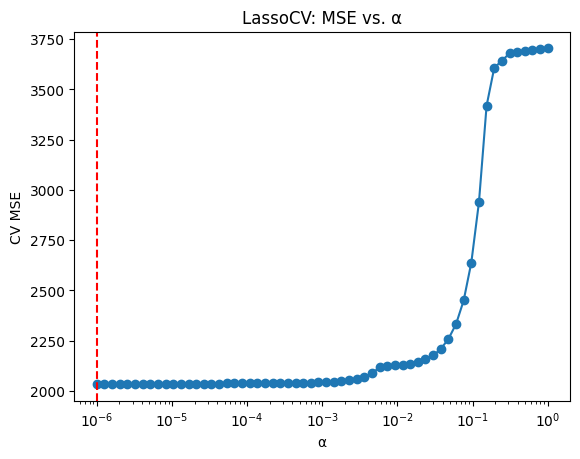


=== Evaluation Metrics Summary ===
                 RMSE  RMSEP_approx (%)        R2        MAE  SMAPE (%)
Train       45.156364          6.012623  0.995989  29.199430  18.814798
Validation  45.076751          6.040738  0.995990  29.196068  18.930944
Test        45.559321          6.091526  0.995909  29.438856  18.899022
Selected Feature Names: Index(['WindSpeed_Mean', 'VoltL1_Mean', 'VoltL2_Mean', 'VoltL3_Mean',
       'CurrentL1_Mean', 'CurrentL2_Mean', 'CurrentL3_Mean',
       'PowerFactor_Mean', 'Frequency_Mean'],
      dtype='object')
Cross-validation MSE scores: [3476.99776418 2843.66132214 1463.3388679  1287.45254353 1732.85543192]
Mean Cross-validation MSE: 2160.861185935539


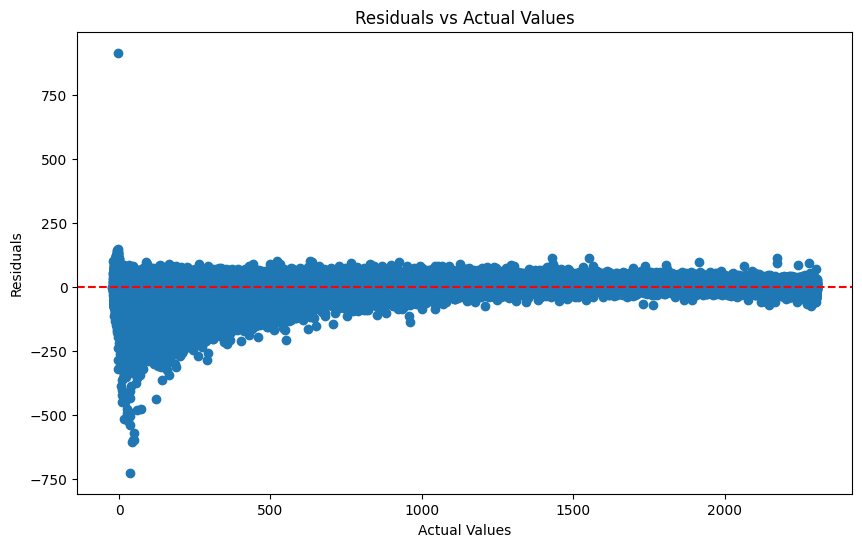

Mean Residuals: -0.3810959429483141
Residual Standard Deviation: 45.744675166274966


In [ ]:
# Create an instance of the MultivariateLassoRegression class
lasso_model = MultivariateLassoRegression(alpha=0.0001, max_iter=1000)

# Run the model with dataframe
result = lasso_model.run(df_MLP, target_column='ActivePower_Mean')

In [ ]:
lasso_model.show_coefficients(df_MLP, 'ActivePower_Mean')

Lasso feature weights (sorted by |coef|):
VoltL1_Mean         6552.537905
VoltL2_Mean        -6343.515976
Frequency_Mean     -4427.949476
VoltL3_Mean         4301.094952
CurrentL1_Mean      2356.063288
WindSpeed_Mean       137.472241
PowerFactor_Mean      50.910906
CurrentL3_Mean       -45.029791
CurrentL2_Mean        44.405958


,0
VoltL1_Mean,6552.537905
VoltL2_Mean,-6343.515976
Frequency_Mean,-4427.949476
VoltL3_Mean,4301.094952
CurrentL1_Mean,2356.063288
WindSpeed_Mean,137.472241
PowerFactor_Mean,50.910906
CurrentL3_Mean,-45.029791
CurrentL2_Mean,44.405958
